## Importing the libs

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt

## Getting the files and creating the directories

The number of epochs is 50, because the model is small and it does not overfit too much at that point

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150
dim = (IMG_HEIGHT, IMG_WIDTH)
scale = 1.0 / 255.0
num_samples=2000

## ImageDataGenerator to read / decode images and convert them into floating point tensors

In [3]:
# Data augmentation for the training set
train_image_generator = ImageDataGenerator(
    train_dir,
    rescale=scale,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',  
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

validation_image_generator = ImageDataGenerator(
    validation_dir, 
    rescale=scale,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_image_generator = ImageDataGenerator(
    test_dir, 
    rescale=scale,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_data_gen = train_image_generator.flow_from_directory(
        directory=train_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
        directory=validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
        directory=PATH,
        classes=['test'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


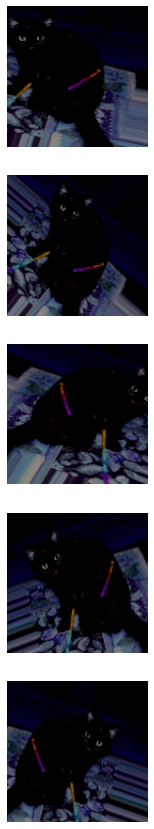

In [5]:
# Print the five first images of the training set

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Creating the model for the neural network with Keras Sequential model. 

Conv2D is a standard convolutional layer that accepts image data. The number 32 for the number of filters is arbitrary but the kernel size of 3x3 is commonly used for image data. In the second Conv2D layer, the number of filters is 64, increasing the number of filters as you go downin the later layers of the network is a common pactice. 

We don`t need to add a "input layer", but we need to specify the "input_shape" on the first layer. The input shape is recieving the height, width and "3" for the color channels.

## Max pooling

Max pooling takes the max value of every region and reduces the dimension of the data. The pool size of 2x2 will reduce the image size by half.

Strides specify how far the pooling window moves for each step 

## Flatten

Flatten will remove all of the dimensions except for one. A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor.


## Dense

A reagular densely-connected layer wich has one node, and uses the sigmoid activation function. If it had two nodes, the activation should be softmax.

In [6]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        3

In [7]:
# For compiling the model we are using binary_crossentropy because we have only one single output node
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Fit the model

- "epochs" is the number of times that the learning algorithm will work through the entire training dataset

- "steps_per_epoch" is typically equal to num_samples / batch_size

- "verbose=0" will show nothing

- "verbose=1" will show you an animated progress bar like this

- "verbose=2" will show the number of epoch



In [8]:
history = model.fit(x=train_data_gen,
                    steps_per_epoch=num_samples // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    verbose=2)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
15/15 - 50s - loss: 0.6951 - accuracy: 0.5112 - val_loss: 0.6860 - val_accuracy: 0.5970
Epoch 2/50
15/15 - 19s - loss: 0.6879 - accuracy: 0.5507 - val_loss: 0.6600 - val_accuracy: 0.6120
Epoch 3/50
15/15 - 20s - loss: 0.6664 - accuracy: 0.5775 - val_loss: 0.6392 - val_accuracy: 0.6260
Epoch 4/50
15/15 - 19s - loss: 0.6563 - accuracy: 0.5903 - val_loss: 0.6269 - val_accuracy: 0.6640
Epoch 5/50
15/15 - 18s - loss: 0.6316 - accuracy: 0.6565 - val_loss: 0.6070 - val_accuracy: 0.6800
Epoch 6/50
15/15 - 19s - loss: 0.6270 - accuracy: 0.6405 - val_loss: 0.6050 - val_accuracy: 0.6800
Epoch 7/50
15/15 - 19s - loss: 0.6102 - accuracy: 0.6693 - val_loss: 0.5994 - val_accuracy: 0.6920
Epoch 8/50
15/15 - 19s - loss: 0.6112 - accuracy: 0.6571 - val_loss: 0.6204 - val_accuracy: 0.6790
Epoch 9/50
15/15 - 19s - loss: 0.6092 - accuracy: 0.6747 - val_loss: 0.6031 - val_accuracy: 0.6560
Epoch 10/50
15/15 - 19s - loss: 0.5973 - accuracy: 0.6699 - val_loss: 0.6053 - val_accuracy: 0.6460
Epoch 11/

## Visualizing the accuracy and loss of the model.

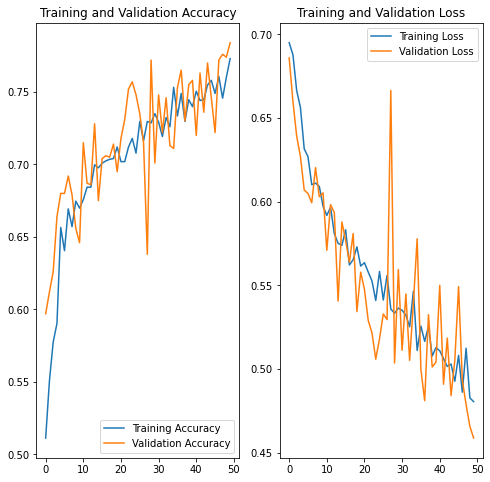

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_images, _ = next(test_data_gen)
probabilities = (model.predict(test_data_gen) > 0.5).astype("int32")
plotImages(test_images, probabilities=probabilities)


In [12]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    if np.round(probability, decimals=0) == answer:
        correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {int(round(percentage_identified, 2) * 100)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 76% of the images of cats and dogs.
You passed the challenge!
